In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import animation

In [79]:
class GeneralGaussianMixture:
    def __init__(self, comps):
        self.gaussians = [ self.toGaussian(*comp) for comp in comps ]

    def toGaussian(self, c, mean, Cov):
        scale = tf.linalg.cholesky(Cov)
        return (c, tfp.distributions.MultivariateNormalTriL(loc=mean, scale_tril=scale))

    def pdf(self, x):
        return tf.reduce_sum([ c * gaussian.prob(tf.cast(x, tf.float32)) for c, gaussian in self.gaussians], axis = 0)

    def dlnprob(self, x):
        with tf.GradientTape() as tape:
            _ = tf.math.log(self.pdf(x))
        return tape.gradient(_, [x])[0]

In [83]:

@tf.function
def selectKernelWidth(euclideanPwDistances):
    pwDistanceMedian = tfp.stats.percentile(
        euclideanPwDistances, 50.0, interpolation='midpoint')

    n = euclideanPwDistances.shape[0]
    return tf.sqrt(0.5 * pwDistanceMedian / tf.convert_to_tensor(np.log(n + 1)))

@tf.function
def euclideanPairwiseDistance(x):
    distance = tf.expand_dims(x, 1) - tf.expand_dims(tf.stop_gradient(x), 0)
    return tf.einsum('ijk,kji->ij', distance, tf.transpose(distance))


class SVGD:
    def __init__(self, x0, lr):
        """Costly precomputations done here - better know the shape of your problem!
        """
        self.x0 = tf.Variable(x0)
        self.opt = tf.keras.optimizers.Adam(lr)

    def update(self, dlnprob, niter, x):
        for _ in range(niter):
            with tf.GradientTape() as tape:
                Kxy = self.rbfkernel(x)
                loss = tf.reduce_sum(Kxy)

            # why minus? see https://github.com/activatedgeek/svgd/issues/1 (right at the end)
            kernelGrad = -tape.gradient(loss, [x])[0]

            # minus to cancel out the negative descent of Adam
            completeGrad = - (Kxy @ dlnprob(x) + kernelGrad) / x.shape[0]
            self.opt.apply_gradients([(completeGrad, x)])

        return x

    @tf.function
    def rbfkernel(self, x):
        normedDist = euclideanPairwiseDistance(x)
        h = tf.stop_gradient(selectKernelWidth(normedDist))
        Kxy = tf.exp(-normedDist / h**2)
        return Kxy


In [84]:
mu = [-5., 0.]
cov = [[ 0.5,  0.],
       [ 0.,  0.5]]

gauss = GeneralGaussianMixture([(0.5, mu, cov), (0.5, [5., 0.], cov)])

x0 = 7 * (2 * tf.random.uniform((100, 2), dtype=tf.float64) - 1)

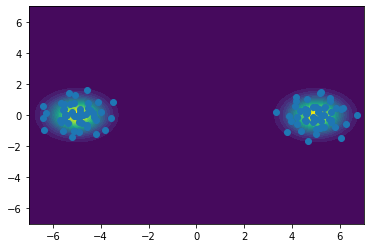

In [85]:
xv, yv = tf.meshgrid(
    tf.linspace(-7, 7, 200),
    tf.linspace(-7, 7, 200)
)
pos_xy = tf.concat([tf.expand_dims(xv, -1), tf.expand_dims(yv, -1)], -1)
pos_xy = tf.cast(pos_xy, dtype=tf.float32)

z = tf.math.exp(tf.math.log(gauss.pdf(pos_xy)))

fig = plt.figure()
ax = plt.axes(xlim=(-7, 7), ylim=(-7, 7))

plt.contourf(xv, yv, z, 25)

svgd = SVGD(x0, 0.1)
x = svgd.x0

scatter = plt.scatter(x[:, 0], x[:, 1])

def animate(_, x): 
    x = svgd.update(gauss.dlnprob, 1, x)
    scatter.set_offsets(x.numpy())
    return x

anim = animation.FuncAnimation(fig, animate, fargs=(x,), frames=100)

anim.save('media/animation.mp4')
